In [ ]:
import argparse
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from torch_frame import stype
import os
import glob
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


# Model imports
from data_provider_pretrain.data_factory import data_provider
from models.time_series_flow_matching_model import TimeSeriesFlowMatchingModel
from models.model9_NS_transformer.flow_matching_models.flow_matching_utils import sample_flow_matching

# Set random seeds
torch.manual_seed(220)
np.random.seed(220)

# Styling
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('default')
sns.set_palette("husl")

print("Imports successful!")


In [ ]:
# Configuration and utility functions from diffusion_analysis.ipynb
class DotDict(dict):
    """A dictionary that supports both dot notation and dictionary access."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__dict__ = self

    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, key, value):
        self.__dict__[key] = value

    def __delattr__(self, item):
        self.__dict__.pop(item, None)

# Flow matching configuration
flow_matching_config = DotDict({
    "num_nodes": 1,
    "task_name": "long_term_forecast",
    "is_training": 1,
    "model_id": "ETTh1_ETTh2_512_192",
    "model": "ns_Transformer",
    "precision": "32",
    "generative_model": "flow_matching",
    "data_pretrain": "Glucose",
    "root_path": "/home/yl2428/Time-LLM/dataset/glucose",
    "data_path": "output_Junt_16_3.csv",
    "data_path_pretrain": "output_Junt_16_3.csv",
    "features": "MS",
    "target": "OT",
    "freq": "t",
    "checkpoints": "/home/yl2428/checkpoints",
    "log_dir": "/home/yl2428/logs",
    "seq_len": 72,
    "label_len": 32,
    "pred_len": 48,
    "seasonal_patterns": "Monthly",
    "stride": 1,
    "enc_in": 9,
    "dec_in": 9,
    "c_out": 9,
    "d_model": 32,
    "n_heads": 8,
    "e_layers": 2,
    "d_layers": 1,
    "d_ff": 256,
    "moving_avg": 25,
    "factor": 3,
    "dropout": 0.1,
    "embed": "timeF",
    "activation": "gelu",
    "output_attention": False,
    "patch_len": 16,
    "prompt_domain": 0,
    "llm_model": "LLAMA",
    "llm_dim": 4096,
    "vae_hidden_dim": 16,
    "col_stats": {'SEX': {'COUNT': (['F', 'M'], [367, 135])}, 'RACE': {'COUNT': (['WHITE', 'NOT REPORTED', 'ASIAN', 'BLACK/AFRICAN AMERICAN', 'MULTIPLE', 'UNKNOWN', 'AMERICAN INDIAN/ALASKAN NATIVE'], [459, 11, 10, 10, 8, 2, 2])}, 'ETHNIC': {'COUNT': (['Not Hispanic or Latino', 'Hispanic or Latino', 'Do not wish to answer', "Don't know"], [472, 15, 13, 2])}, 'ARMCD': {'COUNT': (['RESISTANCE', 'INTERVAL', 'AEROBIC'], [172, 167, 163])}, 'insulin modality': {'COUNT': (['CLOSED LOOP INSULIN PUMP', 'INSULIN PUMP', 'MULTIPLE DAILY INJECTIONS'], [225, 189, 88])}, 'AGE': {'MEAN': 36.655378486055774, 'STD': 13.941209833786187, 'QUANTILES': [18.0, 25.0, 33.0, 45.75, 70.0]}, 'WEIGHT': {'MEAN': 161.39940239043824, 'STD': 30.624877585598654, 'QUANTILES': [103.0, 140.0, 155.0, 179.0, 280.0]}, 'HEIGHT': {'MEAN': 66.72509960159363, 'STD': 3.505847063905933, 'QUANTILES': [58.0, 64.0, 66.0, 69.0, 77.0]}, 'HbA1c': {'MEAN': 6.642828685258964, 'STD': 0.7633658734231158, 'QUANTILES': [4.8, 6.1, 6.6, 7.1, 10.0]}, 'DIABETES_ONSET': {'MEAN': 18.72725737051793, 'STD': 11.889102915798386, 'QUANTILES': [0.0833, 11.0, 16.0, 24.0, 66.0]}},
    "col_names_dict": {stype.categorical: ['ARMCD', 'ETHNIC', 'RACE', 'SEX', 'insulin modality'], stype.numerical: ['AGE', 'DIABETES_ONSET', 'HEIGHT', 'HbA1c', 'WEIGHT']},
    "num_workers": 10,
    "itr": 1,
    "train_epochs": 100,
    "align_epochs": 10,
    "ema_decay": 0.995,
    "batch_size": 512,  # Updated from 256 to 64
    "eval_batch_size": 512,  # Updated from 256 to 8
    "patience": 40,  # Updated from 10 to 40
    "learning_rate": 0.0001,
    "des": "Exp",
    "loss": "MSE",
    "lradj": "COS",
    "pct_start": 0.2,
    "use_amp": False,
    "llm_layers": 32,
    "percent": 100,
    "num_individuals": -1,  # Updated from 100 to -1
    "enable_covariates": 1,
    "cov_type": "tensor",
    "gradient_accumulation_steps": 1,
    "use_deep_speed": 1,
    "wandb": 1,
    "wandb_group": None,
    "wandb_api_key": "6f1080f993d5d7ad6103e69ef57dd9291f1bf366",
    "use_moe": 1,
    "num_experts": 8,
    "latent_len": 36,
    "top_k_experts": 4,
    "moe_layer_indices": [0, 1],
    "moe_loss_weight": 0.01,
    "log_routing_stats": 1,
    "num_universal_experts": 1,
    "universal_expert_weight": 0.3,
    "head_dropout": 0.1,
    "channel_independence": 0,
    "decomp_method": "moving_avg",
    "use_norm": 1,
    "down_sampling_layers": 2,
    "down_sampling_window": 1,
    "down_sampling_method": "avg",
    "use_future_temporal_feature": 0,
    "k_z": 1e-2,
    "k_cond": 0.001,  # Updated from 1 to 0.001
    "d_z": 8,
    "p_hidden_dims": [64, 64],
    "p_hidden_layers": 2,
    "diffusion_config_dir": "/home/yl2428/Time-LLM/models/model9_NS_transformer/configs/toy_8gauss.yml",
    "cond_pred_model_pertrain_dir": None,
    "CART_input_x_embed_dim": 32,
    "mse_timestep": 0,
    "MLP_diffusion_net": False,
    "timesteps": 50,
    "ode_solver": "dopri5",
    "ode_rtol": 1e-5,
    "ode_atol": 1e-5,
    "interpolation_type": "linear",
    "expert_layers": 2,
    # Additional fields from JSON that were missing:
    "loader": "modal",
    "model_comment": "none",
    "enable_context_aware": 1,
    "glucose_dropout_rate": 0.4,
    "use_contrastive_learning": 1,
    "contrastive_loss_weight": 0.1,
    "contrastive_temperature": 0.1,
    "use_momentum_encoder": 1,
    "momentum_factor": 0.999
})

def find_best_checkpoint(base_path="/home/yl2428/logs/ns_Transformer/flow_matching/comfy-dust-243", metric="val_loss"):
    """Find the best checkpoint based on validation loss."""
    print(f"Searching for checkpoints in: {base_path}")
    
    checkpoint_pattern = os.path.join(base_path, "checkpoints/epoch=*-step=*-val_loss=*.ckpt/checkpoint")
    print(checkpoint_pattern)
    checkpoint_dirs = glob.glob(checkpoint_pattern)
    
    if not checkpoint_dirs:
        print("No checkpoints found!")
        return None, None, None
    
    best_checkpoint = None
    best_metric = float('inf')
    best_run = None
    
    print(f"Found {len(checkpoint_dirs)} checkpoints:")
    
    for checkpoint_dir in checkpoint_dirs:
        pattern = r'epoch=(\d+)-step=(\d+)-val_loss=([\d.]+)\.ckpt'
        match = re.search(pattern, checkpoint_dir)
        
        if match:
            epoch, step, val_loss = match.groups()
            val_loss = float(val_loss)
            run_name = checkpoint_dir.split('/')[-4]
            
            print(f"  - {run_name}: epoch={epoch}, step={step}, val_loss={val_loss:.4f}")
            
            if val_loss < best_metric:
                best_metric = val_loss
                best_checkpoint = checkpoint_dir
                best_run = run_name
    
    if best_checkpoint:
        print(f"\nBest checkpoint: {best_run}")
        print(f"  - Path: {best_checkpoint}")
        print(f"  - Val Loss: {best_metric:.4f}")
    
    return best_checkpoint, best_metric, best_run


def load_deepspeed_checkpoint(model, checkpoint_path):
    """Load DeepSpeed checkpoint into the model."""
    print(f"Loading DeepSpeed checkpoint from: {checkpoint_path}")
    
    model_states_path = os.path.join(checkpoint_path, "mp_rank_00_model_states.pt")
    
    if not os.path.exists(model_states_path):
        raise FileNotFoundError(f"Model states file not found: {model_states_path}")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    checkpoint = torch.load(model_states_path, map_location=device)
    
    if 'module' in checkpoint:
        state_dict = checkpoint['module']
    elif 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    
    cleaned_state_dict = {}
    for key, value in state_dict.items():
        clean_key = key
        if key.startswith('_forward_module.'):
            clean_key = key.replace('_forward_module.', '')
        elif key.startswith('module.'):
            clean_key = key.replace('module.', '')
        
        if isinstance(value, torch.Tensor):
            value = value.to(device)
        
        cleaned_state_dict[clean_key] = value
    
    try:
        model = model.to(device)
        missing_keys, unexpected_keys = model.load_state_dict(cleaned_state_dict, strict=False)
        
        if missing_keys:
            print(f"Missing keys: {missing_keys[:10]}{'...' if len(missing_keys) > 10 else ''}")
        if unexpected_keys:
            print(f"Unexpected keys: {unexpected_keys[:10]}{'...' if len(unexpected_keys) > 10 else ''}")
            
        print("✓ Model weights loaded successfully!")
        
    except Exception as e:
        print(f"Warning: Some keys couldn't be loaded: {e}")
        model_dict = model.state_dict()
        pretrained_dict = {k: v for k, v in cleaned_state_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        
        model = model.to(device)
        model.load_state_dict(model_dict)
        print(f"✓ Loaded {len(pretrained_dict)}/{len(cleaned_state_dict)} parameters")
    
    model = model.to(device)
    print(f"✓ All model components moved to {device}")
    
    return model

print("Checkpoint loading functions defined!")
# Load the flow matching model and data
print("Loading flow matching model and data...")

# # Load data
flow_args = flow_matching_config
train_data_fm, train_loader_fm, flow_args = data_provider(
    flow_args, flow_args.data_pretrain, flow_args.data_path_pretrain, True, 'train'
)
vali_data_fm, vali_loader_fm, flow_args = data_provider(
    flow_args, flow_args.data_pretrain, flow_args.data_path_pretrain, True, 'val'
)
test_data_fm, test_loader_fm, flow_args = data_provider(
    flow_args, flow_args.data_pretrain, flow_args.data_path_pretrain, False, 'test'
)

# Initialize model
flow_matching_model = TimeSeriesFlowMatchingModel(flow_args, train_loader_fm, vali_loader_fm, test_loader_fm)

# Find and load best checkpoint
checkpoint_path, best_metric, run_name = find_best_checkpoint()

if checkpoint_path:
    flow_matching_model = load_deepspeed_checkpoint(flow_matching_model, checkpoint_path)
    flow_matching_model.eval()
    print(f"✓ Model loaded from {run_name} with val_loss: {best_metric:.4f}")
else:
    print("No checkpoint found - using untrained model")
    flow_matching_model.eval()

print(f"Model on device: {next(flow_matching_model.parameters()).device}")
print(f"Model type: {flow_args.model}")
print(f"Covariates enabled: {flow_args.enable_covariates}")
print(f"Batch size: {flow_args.batch_size}")


In [ ]:
test_loader = test_loader_fm
print("✓ Data and model loaded successfully!")

In [ ]:
# Initialize model
try:
    model = flow_matching_model
    print("Model initialized successfully!")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"MoE enabled: {model.use_moe}")
    print(f"Number of experts: {model.num_experts}")
    print(f"Contrastive learning: {model.use_contrastive_learning}")
except Exception as e:
    print(f"Error initializing model: {e}")
    print("Please ensure the model file and dependencies are available")


In [30]:
def extract_context_embeddings_and_routing(model, dataloader, config, device, num_batches=10):
    """
    Extract context embeddings and expert routing weights from the flow matching model
    """
    model.eval()
    
    context_embeddings = []
    routing_weights = []
    covariate_data = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            if batch_idx >= num_batches:
                break
                
            try:
                # Handle the data format from flow matching model
                print(f"Batch {batch_idx}: batch contains {len(batch)} items")
                
                # Flow matching model data format
                if len(batch) == 2:
                    # batch[0] contains (batch_x, batch_y, batch_x_mark, batch_y_mark)
                    # batch[1] contains batch_cov (covariates)
                    batch_x, batch_y, batch_x_mark, batch_y_mark = batch[0]
                    batch_cov = batch[1]
                    
                    # Move to device
                    batch_x = batch_x.float().to(device)
                    batch_y = batch_y.float().to(device)
                    batch_x_mark = batch_x_mark.float().to(device)
                    batch_y_mark = batch_y_mark.float().to(device)
                    batch_cov = batch_cov.to(device)
                    
                    # Create decoder input (following time_series_flow_matching_model.py)
                    dec_inp = torch.zeros_like(batch_y[:, -config.pred_len:, :]).float()
                    dec_inp = torch.cat([batch_y[:, :config.label_len, :], dec_inp], dim=1).float().to(device)
                    
                    # Extract covariates data for analysis and denormalize
                    # Original normalization stats from preprocessing
                    feature_means = np.array([0.84085476, 0.80213351, 79.40491332, 32.5294183, 0.24537674, 
                                            5.3128258, 3.82292609, 5.69710292, 144.81223086])
                    feature_stds = np.array([1.61659338, 0.60898286, 19.36734307, 86.98838521, 0.43031035, 
                                           14.4286974, 11.59240125, 11.53828031, 55.07849221])
                    
                    # Extract and denormalize features
                    step_count_norm = batch_x[:, :, 3].cpu().numpy()
                    heart_rate_norm = batch_x[:, :, 2].cpu().numpy()
                    meal_carbs_norm = batch_x[:, :, 7].cpu().numpy()
                    sleep_quality_norm = batch_x[:, :, 4].cpu().numpy()
                    
                    # Denormalize: value = (normalized_value * std) + mean
                    covariate_dict = {
                        'step_count': (step_count_norm * feature_stds[3]) + feature_means[3],
                        'heart_rate': (heart_rate_norm * feature_stds[2]) + feature_means[2],
                        'meal_carbs': (meal_carbs_norm * feature_stds[7]) + feature_means[7],
                        'sleep_quality': (sleep_quality_norm * feature_stds[4]) + feature_means[4],
                    }
                    
                else:
                    print(f"Unexpected batch structure with {len(batch)} items")
                    continue
                
                # Hook to capture intermediate outputs from condition model
                captured_context = None
                captured_routing = {}
                
                def context_hook(module, input, output):
                    nonlocal captured_context
                    # From ns_Transformer.py, context embeddings are the 5th return value
                    if isinstance(output, tuple) and len(output) >= 5:
                        captured_context = output[4].detach().cpu()  # combined_invariant_cov
                
                def routing_hook(layer_name):
                    def hook(module, input, output):
                        nonlocal captured_routing
                        if isinstance(output, tuple) and len(output) >= 3:
                            captured_routing[layer_name] = output[2].detach().cpu()  # routing weights
                    return hook
                
                # Register hooks on the condition model (ns_Transformer)
                cond_model = model.cond_pred_model
                main_hook = cond_model.register_forward_hook(context_hook)
                
                routing_hooks = []
                # Check for MoE layers - handle both ns_Transformer and ns_DLinear
                if hasattr(cond_model, 'use_moe') and getattr(cond_model, 'use_moe', False):
                    # For ns_Transformer: multiple MoE layers at specific indices
                    moe_layer_indices = getattr(cond_model, 'moe_layer_indices', None)
                    if moe_layer_indices is not None:
                        for layer_idx in moe_layer_indices:
                            if hasattr(cond_model, 'moe_layers') and str(layer_idx) in cond_model.moe_layers:
                                hook = cond_model.moe_layers[str(layer_idx)].register_forward_hook(
                                    routing_hook(f'layer_{layer_idx}')
                                )
                                routing_hooks.append(hook)
                    
                    # For ns_DLinear: single MoE decoder
                    elif hasattr(cond_model, 'moe_decoder'):
                        hook = cond_model.moe_decoder.register_forward_hook(
                            routing_hook('moe_decoder')
                        )
                        routing_hooks.append(hook)
                    
                    # Fallback: try to find MoE layers by checking all submodules
                    else:
                        for name, module in cond_model.named_modules():
                            if 'moe' in name.lower() or 'expert' in name.lower():
                                hook = module.register_forward_hook(routing_hook(f'module_{name}'))
                                routing_hooks.append(hook)
                
                # Forward pass through condition model to get context embeddings
                # This follows the condition_model_forward method from time_series_flow_matching_model.py
                if hasattr(model, 'condition_model_forward'):
                    y_0_hat_batch, KL_loss, z_sample, cov_embedding = model.condition_model_forward(
                        batch_x, batch_x_mark, dec_inp, batch_y_mark, covariates=batch_cov
                    )
                else:
                    # Direct call to condition model
                    result = cond_model(batch_x, batch_x_mark, dec_inp, batch_y_mark, covariates=batch_cov)
                    if isinstance(result, tuple) and len(result) >= 5:
                        cov_embedding = result[4]
                    else:
                        cov_embedding = None
                
                # Remove hooks
                main_hook.remove()
                for hook in routing_hooks:
                    hook.remove()
                
                # Store results
                if captured_context is not None:
                    context_embeddings.append(captured_context)
                    routing_weights.append(captured_routing)
                    covariate_data.append(covariate_dict)
                elif cov_embedding is not None:
                    # Fallback: use cov_embedding directly
                    context_embeddings.append(cov_embedding.detach().cpu())
                    routing_weights.append(captured_routing)
                    covariate_data.append(covariate_dict)
                
                print(f"Processed batch {batch_idx + 1}/{num_batches}")
                
            except Exception as e:
                print(f"Error processing batch {batch_idx}: {e}")
                import traceback
                traceback.print_exc()
                continue
    
    return context_embeddings, routing_weights, covariate_data

# Extract embeddings and routing weights
print("Extracting context embeddings and expert routing weights...")
context_embeddings, routing_weights, covariate_data = extract_context_embeddings_and_routing(
    model, test_loader, flow_matching_config, model.device, num_batches=10
)

print(f"Extracted {len(context_embeddings)} batches of context embeddings")
if context_embeddings:
    print(f"Context embedding shape: {context_embeddings[0].shape}")
if routing_weights:
    print(f"Routing weights available for layers: {list(routing_weights[0].keys())}")


Extracting context embeddings and expert routing weights...
Batch 0: batch contains 2 items
Error in MoE logging: You must call wandb.init() before wandb.log()
Routing info shapes: [('layer_0', torch.Size([512, 8])), ('layer_1', torch.Size([512, 8]))]
Processed batch 1/10
Batch 1: batch contains 2 items
Error in MoE logging: You must call wandb.init() before wandb.log()
Routing info shapes: [('layer_0', torch.Size([512, 8])), ('layer_1', torch.Size([512, 8]))]
Processed batch 2/10
Batch 2: batch contains 2 items
Error in MoE logging: You must call wandb.init() before wandb.log()
Routing info shapes: [('layer_0', torch.Size([512, 8])), ('layer_1', torch.Size([512, 8]))]
Processed batch 3/10
Batch 3: batch contains 2 items
Error in MoE logging: You must call wandb.init() before wandb.log()
Routing info shapes: [('layer_0', torch.Size([512, 8])), ('layer_1', torch.Size([512, 8]))]
Processed batch 4/10
Batch 4: batch contains 2 items
Error in MoE logging: You must call wandb.init() before 

In [31]:
# now concatnate all the batches into one tensor
# Concatenate all batches into one tensor
print("Concatenating all batches into single tensors...")

# Concatenate context embeddings from all batches
if context_embeddings:
    all_context_embeddings = torch.cat(context_embeddings, dim=0)
    print(f"Concatenated context embeddings shape: {all_context_embeddings.shape}")
else:
    print("No context embeddings to concatenate")
    all_context_embeddings = None

# Concatenate covariate data from all batches
if covariate_data:
    all_covariates = {}
    for cov_name in ['step_count', 'heart_rate', 'meal_carbs', 'sleep_quality']:
        cov_values = []
        for batch_idx in range(len(covariate_data)):
            batch_cov = covariate_data[batch_idx][cov_name]
            if cov_name == 'step_count':
                batch_means = np.sum(batch_cov, axis=1)
            # Average across time dimension for each sample
            batch_means = np.mean(batch_cov, axis=1)  # Shape: (batch_size,)
            cov_values.extend(batch_means)
        
        all_covariates[cov_name] = np.array(cov_values)
    
    print(f"Concatenated covariate data:")
    for cov_name, cov_values in all_covariates.items():
        print(f"  {cov_name}: {cov_values.shape}")
else:
    print("No covariate data to concatenate")
    all_covariates = {}

# Concatenate routing weights if available
if routing_weights and any(routing_weights):
    all_routing_weights = {}
    for layer_name in routing_weights[0].keys():
        layer_weights = []
        for batch_routing in routing_weights:
            if layer_name in batch_routing and batch_routing[layer_name].shape[0] > 0:
                layer_weights.append(batch_routing[layer_name])
        
        if layer_weights:
            all_routing_weights[layer_name] = torch.cat(layer_weights, dim=0)
            print(f"Concatenated routing weights for {layer_name}: {all_routing_weights[layer_name].shape}")
    
    print(f"Available routing layers: {list(all_routing_weights.keys())}")
else:
    print("No routing weights to concatenate")
    all_routing_weights = {}

print(f"\nFinal concatenated shapes:")
if all_context_embeddings is not None:
    print(f"- Context embeddings: {all_context_embeddings.shape}")
if all_covariates:
    print(f"- Covariate samples: {len(next(iter(all_covariates.values())))}")
if all_routing_weights:
    for layer_name, weights in all_routing_weights.items():
        print(f"- {layer_name} routing weights: {weights.shape}")

print("Concatenation complete!")

Concatenating all batches into single tensors...
Concatenated context embeddings shape: torch.Size([5120, 32])
Concatenated covariate data:
  step_count: (5120,)
  heart_rate: (5120,)
  meal_carbs: (5120,)
  sleep_quality: (5120,)
Concatenated routing weights for layer_0: torch.Size([5120, 8])
Concatenated routing weights for layer_1: torch.Size([5120, 8])
Available routing layers: ['layer_0', 'layer_1']

Final concatenated shapes:
- Context embeddings: torch.Size([5120, 32])
- Covariate samples: 5120
- layer_0 routing weights: torch.Size([5120, 8])
- layer_1 routing weights: torch.Size([5120, 8])
Concatenation complete!


In [32]:
# Reduce dimensionality first with PCA for better t-SNE performance
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
%matplotlib inline

print("Applying PCA preprocessing on ALL batches...")
pca = PCA(n_components=30)  # Reduce to 30 dimensions first
embeddings_pca = pca.fit_transform(all_context_embeddings)
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_[:5]}")
print(f"Cumulative explained variance: {np.cumsum(pca.explained_variance_ratio_)[:10]}")

# Apply t-SNE
print("Applying t-SNE on ALL batches...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

print(f"t-SNE completed. Shape: {embeddings_tsne.shape}")
if all_context_embeddings is not None:
    print(f"Total samples from all batches: {all_context_embeddings.shape[0]}")
else:
    print("Warning: No context embeddings available")



Applying PCA preprocessing on ALL batches...
PCA explained variance ratio: [0.59208179 0.14347958 0.08535719 0.05795202 0.02485376]
Cumulative explained variance: [0.59208179 0.73556137 0.82091855 0.87887057 0.90372433 0.92444205
 0.93973503 0.95076853 0.96051616 0.96714334]
Applying t-SNE on ALL batches...
t-SNE completed. Shape: (5120, 2)
Total samples from all batches: 5120


In [19]:
# Use the already concatenated covariate data from ALL batches
print("Using concatenated covariate data from ALL batches...")
print(f"Available concatenated covariates: {list(all_covariates.keys())}")
print(f"Total samples in concatenated data: {len(next(iter(all_covariates.values())))}")

# Create DataFrame for t-SNE results
df_tsne = pd.DataFrame({
    'tsne_1': embeddings_tsne[:, 0],
    'tsne_2': embeddings_tsne[:, 1]
})

# Add covariate information to DataFrame
for cov_name, cov_values in all_covariates.items():
    if len(cov_values) == len(df_tsne):
        df_tsne[cov_name] = cov_values
    else:
        print(f"Warning: {cov_name} has {len(cov_values)} values but expected {len(df_tsne)}")

print(f"t-SNE DataFrame shape: {df_tsne.shape}")
print(f"Available covariates: {list(all_covariates.keys())}")

# Perform clustering on ALL context embeddings from all batches
print("\nPerforming clustering analysis on ALL batches...")
from sklearn.cluster import KMeans

# Determine optimal number of clusters using elbow method
max_k = 10
inertias = []
silhouette_scores = []

from sklearn.metrics import silhouette_score

for k in range(5, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(embeddings_pca)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(embeddings_pca, cluster_labels))

# Use optimal k based on silhouette score
optimal_k = int(np.argmax(silhouette_scores) + 5)  # +2 because we started from k=2
print(f"Optimal number of clusters: {optimal_k}")

# Apply K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(embeddings_pca)

# Add cluster labels to DataFrame
df_tsne['cluster'] = cluster_labels

print(f"Clustering completed. Silhouette score: {silhouette_scores[optimal_k-2]:.3f}")

# Create cluster summary statistics
cluster_summary = {}
for cluster_id in range(optimal_k):
    cluster_mask = cluster_labels == cluster_id
    cluster_summary[cluster_id] = {
        'size': np.sum(cluster_mask),
        'step_count_mean': np.sum(all_covariates['step_count'][cluster_mask]),
        'heart_rate_mean': np.mean(all_covariates['heart_rate'][cluster_mask]),
        'meal_carbs_mean': np.mean(all_covariates['meal_carbs'][cluster_mask]),
        'sleep_quality_mean': np.mean(all_covariates['sleep_quality'][cluster_mask])
    }

print("\nCluster summary:")
for cluster_id, stats in cluster_summary.items():
    print(f"Cluster {cluster_id}: {stats['size']} samples")
    print(f"  Step count: {stats['step_count_mean']:.2f}")
    print(f"  Heart rate: {stats['heart_rate_mean']:.2f}")
    print(f"  Meal carbs: {stats['meal_carbs_mean']:.2f}")
    print(f"  Sleep quality: {stats['sleep_quality_mean']:.2f}")
    print()

# Calculate correlation between clusters and behavioral contexts
print("Calculating correlations between clusters and behavioral contexts...")

# Create dummy variables for clusters
from sklearn.preprocessing import LabelEncoder
from scipy.stats import spearmanr

correlations = {}
for cov_name in ['step_count', 'heart_rate', 'meal_carbs', 'sleep_quality']:
    # Calculate Spearman correlation between cluster labels and covariate values
    correlation, p_value = spearmanr(cluster_labels, all_covariates[cov_name])
    correlations[cov_name] = {'correlation': correlation, 'p_value': p_value}

print("\nCorrelations between clusters and behavioral contexts:")
for cov_name, stats in correlations.items():
    print(f"{cov_name}: r = {stats['correlation']:.3f}, p = {stats['p_value']:.3f}")

# Statistical significance test for cluster differences
from scipy.stats import f_oneway, kruskal

anova_results = {}
for cov_name in ['step_count', 'heart_rate', 'meal_carbs', 'sleep_quality']:
    cluster_groups = [all_covariates[cov_name][cluster_labels == i] for i in range(optimal_k)]
    
    # Use Kruskal-Wallis test (non-parametric alternative to ANOVA)
    h_stat, p_value = kruskal(*cluster_groups)
    anova_results[cov_name] = {'h_statistic': h_stat, 'p_value': p_value}

print("\nKruskal-Wallis test for cluster differences:")
for cov_name, stats in anova_results.items():
    print(f"{cov_name}: H = {stats['h_statistic']:.3f}, p = {stats['p_value']:.3f}")

df_tsne.head()


Using concatenated covariate data from ALL batches...
Available concatenated covariates: ['step_count', 'heart_rate', 'meal_carbs', 'sleep_quality']
Total samples in concatenated data: 25600
t-SNE DataFrame shape: (25600, 6)
Available covariates: ['step_count', 'heart_rate', 'meal_carbs', 'sleep_quality']

Performing clustering analysis on ALL batches...
Optimal number of clusters: 5
Clustering completed. Silhouette score: 0.186

Cluster summary:
Cluster 0: 5037 samples
  Step count: 81372.60
  Heart rate: 71.75
  Meal carbs: 3.66
  Sleep quality: 0.45

Cluster 1: 8580 samples
  Step count: 319387.31
  Heart rate: 81.68
  Meal carbs: 6.66
  Sleep quality: 0.19

Cluster 2: 5541 samples
  Step count: 184186.98
  Heart rate: 81.94
  Meal carbs: 6.08
  Sleep quality: 0.22

Cluster 3: 1073 samples
  Step count: 31517.76
  Heart rate: 85.24
  Meal carbs: 5.70
  Sleep quality: 0.24

Cluster 4: 5369 samples
  Step count: 106282.75
  Heart rate: 73.52
  Meal carbs: 3.64
  Sleep quality: 0.40

C

,tsne_1,tsne_2,step_count,heart_rate,meal_carbs,sleep_quality,cluster
0,-64.168968,81.317551,5.979438,65.572685,0.196442,0.888889,0
1,-51.404793,46.522861,79.994087,87.966202,6.965620,0.000000,4
2,10.906725,-16.479027,34.841961,117.375923,7.664888,0.000000,1
3,-89.369278,-6.076803,5.143582,71.445374,3.321453,0.527778,0
4,-98.171143,-66.707520,70.859673,81.971413,3.354546,0.277778,0


Creating visualizations...


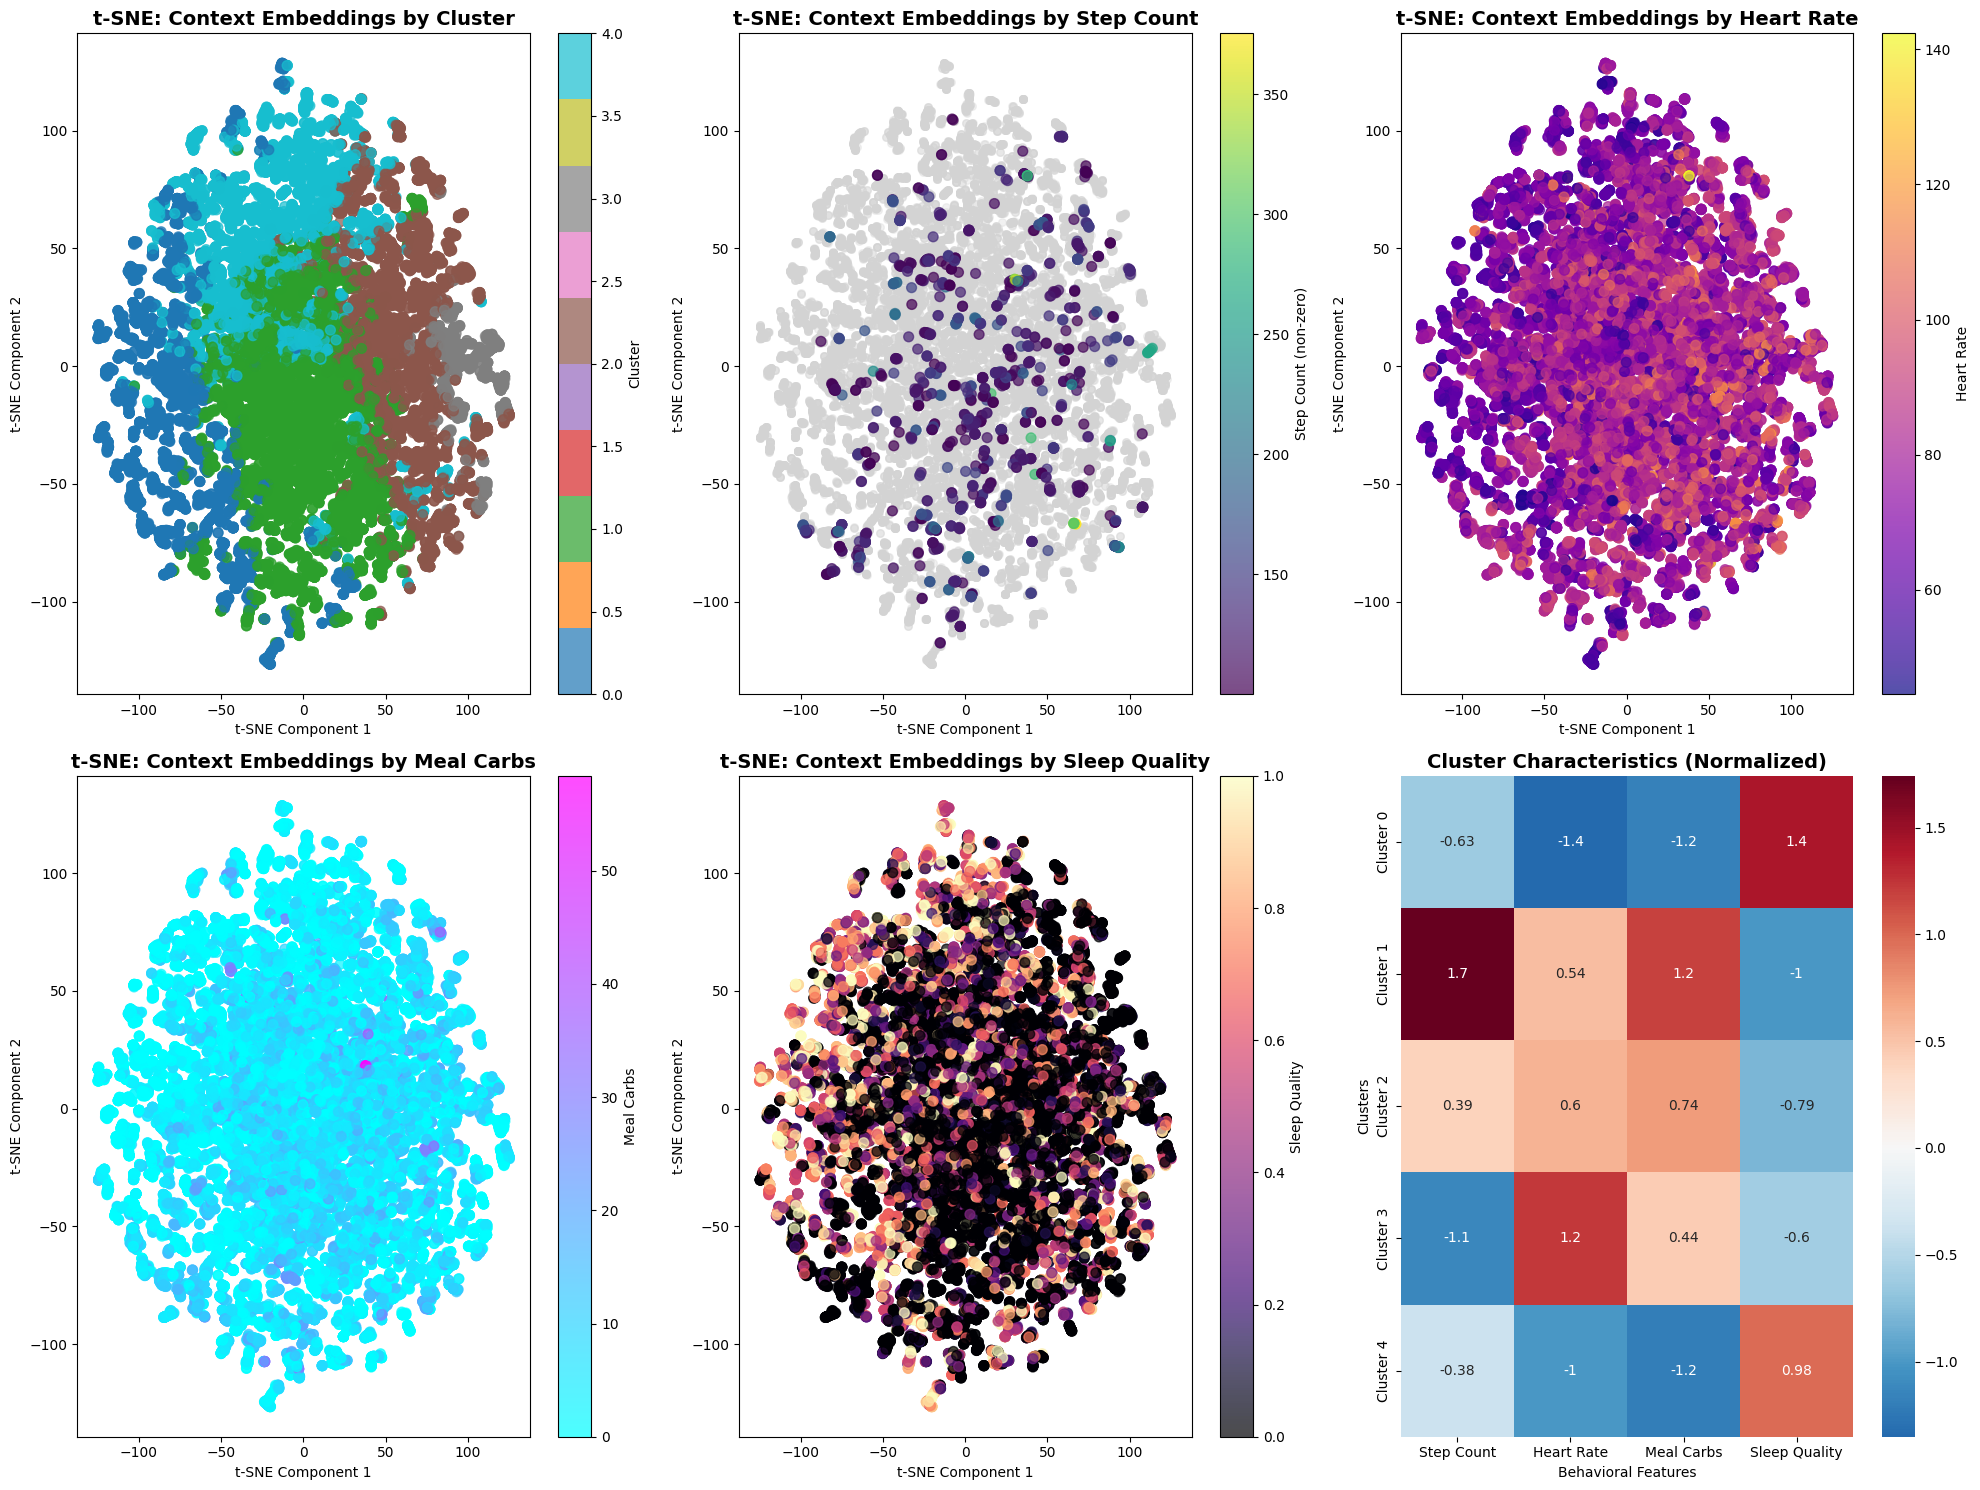


DETAILED ANALYSIS RESULTS

Dataset Information:
- Total samples analyzed: 25600
- Context embedding dimensions: 32
- Optimal number of clusters: 5
- Clustering silhouette score: 0.186

Cluster Distribution:
- Cluster 0: 5037 samples (19.7%)
- Cluster 1: 8580 samples (33.5%)
- Cluster 2: 5541 samples (21.6%)
- Cluster 3: 1073 samples (4.2%)
- Cluster 4: 5369 samples (21.0%)

Behavioral Context Correlations with Clusters:
- step_count: r = 0.002, p = 0.733 
- heart_rate: r = 0.037, p = 0.000 **
- meal_carbs: r = -0.050, p = 0.000 **
- sleep_quality: r = -0.014, p = 0.030 *

Statistical Tests (Kruskal-Wallis):
- step_count: H = 2716.698, p = 0.000 **
- heart_rate: H = 3102.122, p = 0.000 **
- meal_carbs: H = 1667.715, p = 0.000 **
- sleep_quality: H = 2394.873, p = 0.000 **

Note: * p < 0.05, ** p < 0.01


In [33]:
# Create comprehensive visualizations
print("Creating visualizations...")

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 12)

# Create a large subplot layout
fig = plt.figure(figsize=(20, 15))

# 1. t-SNE visualization with clusters
ax1 = plt.subplot(2, 3, 1)
scatter = ax1.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], 
                     c=df_tsne['cluster'], cmap='tab10', alpha=0.7, s=50)
ax1.set_title('t-SNE: Context Embeddings by Cluster', fontsize=14, fontweight='bold')
ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')
plt.colorbar(scatter, ax=ax1, label='Cluster')

ax2 = plt.subplot(2, 3, 2)
mask_zero = df_tsne['step_count'] <= 100
mask_nonzero = df_tsne['step_count'] > 100

# Plot zeros first (in gray)
if mask_zero.any():
    ax2.scatter(df_tsne[mask_zero]['tsne_1'], df_tsne[mask_zero]['tsne_2'],
                c='lightgray', alpha=0.3, s=30, label='Zero steps')

# Plot non-zeros with colormap
scatter2 = ax2.scatter(df_tsne[mask_nonzero]['tsne_1'], df_tsne[mask_nonzero]['tsne_2'],
                       c=df_tsne[mask_nonzero]['step_count'], cmap='viridis', alpha=0.7, s=50)

ax2.set_title('t-SNE: Context Embeddings by Step Count', fontsize=14, fontweight='bold')
ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')
plt.colorbar(scatter2, ax=ax2, label='Step Count (non-zero)')

# 3. t-SNE colored by heart rate
ax3 = plt.subplot(2, 3, 3)
scatter3 = ax3.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], 
                      c=df_tsne['heart_rate'], cmap='plasma', alpha=0.7, s=50)
ax3.set_title('t-SNE: Context Embeddings by Heart Rate', fontsize=14, fontweight='bold')
ax3.set_xlabel('t-SNE Component 1')
ax3.set_ylabel('t-SNE Component 2')
plt.colorbar(scatter3, ax=ax3, label='Heart Rate')

# 4. t-SNE colored by meal carbs
ax4 = plt.subplot(2, 3, 4)
scatter4 = ax4.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], 
                      c=df_tsne['meal_carbs'], cmap='cool', alpha=0.7, s=50)
ax4.set_title('t-SNE: Context Embeddings by Meal Carbs', fontsize=14, fontweight='bold')
ax4.set_xlabel('t-SNE Component 1')
ax4.set_ylabel('t-SNE Component 2')
plt.colorbar(scatter4, ax=ax4, label='Meal Carbs')

# 5. t-SNE colored by sleep quality
ax5 = plt.subplot(2, 3, 5)
scatter5 = ax5.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], 
                      c=df_tsne['sleep_quality'], cmap='magma', alpha=0.7, s=50)
ax5.set_title('t-SNE: Context Embeddings by Sleep Quality', fontsize=14, fontweight='bold')
ax5.set_xlabel('t-SNE Component 1')
ax5.set_ylabel('t-SNE Component 2')
plt.colorbar(scatter5, ax=ax5, label='Sleep Quality')

# 6. Cluster characteristics heatmap
ax6 = plt.subplot(2, 3, 6)
cluster_data = []
cluster_labels_list = []
for cluster_id in range(optimal_k):
    cluster_data.append([
        cluster_summary[cluster_id]['step_count_mean'],
        cluster_summary[cluster_id]['heart_rate_mean'],
        cluster_summary[cluster_id]['meal_carbs_mean'],
        cluster_summary[cluster_id]['sleep_quality_mean']
    ])
    cluster_labels_list.append(f'Cluster {cluster_id}')

cluster_df = pd.DataFrame(cluster_data)
cluster_df.columns = ['Step Count', 'Heart Rate', 'Meal Carbs', 'Sleep Quality']
cluster_df.index = cluster_labels_list

# Normalize the data for better visualization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cluster_df_norm = pd.DataFrame(scaler.fit_transform(cluster_df))
cluster_df_norm.columns = cluster_df.columns
cluster_df_norm.index = cluster_df.index

sns.heatmap(cluster_df_norm, annot=True, cmap='RdBu_r', center=0, ax=ax6)
ax6.set_title('Cluster Characteristics (Normalized)', fontsize=14, fontweight='bold')
ax6.set_xlabel('Behavioral Features')
ax6.set_ylabel('Clusters')

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\n" + "="*80)
print("DETAILED ANALYSIS RESULTS")
print("="*80)

print(f"\nDataset Information:")
print(f"- Total samples analyzed: {len(df_tsne)}")
print(f"- Context embedding dimensions: {all_context_embeddings.shape[1] if all_context_embeddings is not None else 'N/A'}")
print(f"- Optimal number of clusters: {optimal_k}")
print(f"- Clustering silhouette score: {silhouette_scores[optimal_k-2]:.3f}")

print(f"\nCluster Distribution:")
cluster_counts = df_tsne['cluster'].value_counts().sort_index()
for cluster_id in range(optimal_k):
    percentage = (cluster_counts[cluster_id] / len(df_tsne)) * 100
    print(f"- Cluster {cluster_id}: {cluster_counts[cluster_id]} samples ({percentage:.1f}%)")

print(f"\nBehavioral Context Correlations with Clusters:")
for cov_name, stats in correlations.items():
    significance = "**" if stats['p_value'] < 0.01 else "*" if stats['p_value'] < 0.05 else ""
    print(f"- {cov_name}: r = {stats['correlation']:.3f}, p = {stats['p_value']:.3f} {significance}")

print(f"\nStatistical Tests (Kruskal-Wallis):")
for cov_name, stats in anova_results.items():
    significance = "**" if stats['p_value'] < 0.01 else "*" if stats['p_value'] < 0.05 else ""
    print(f"- {cov_name}: H = {stats['h_statistic']:.3f}, p = {stats['p_value']:.3f} {significance}")

print(f"\nNote: * p < 0.05, ** p < 0.01")
print("="*80)


In [ ]:
# Enhanced Step Count Visualization - Making Non-Zero Values More Prominent
print("Creating enhanced step count visualization...")

# Check current step count distribution
step_count_values = all_covariates['step_count']
zero_count = np.sum(step_count_values == 0)
nonzero_count = np.sum(step_count_values > 0)
print(f"Step count distribution: {zero_count} zeros, {nonzero_count} non-zeros")

# Create enhanced visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Standard visualization (top-left)
ax1 = axes[0, 0]
scatter1 = ax1.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], 
                      c=step_count_values, cmap='viridis', alpha=0.7, s=50)
ax1.set_title('Standard Step Count Visualization', fontsize=14, fontweight='bold')
ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')
plt.colorbar(scatter1, ax=ax1, label='Step Count')

# 2. Enhanced visualization with separate zero/non-zero plotting (top-right)
ax2 = axes[0, 1]
zero_mask = step_count_values == 0
nonzero_mask = step_count_values > 0

# Plot zero values in light gray
if np.any(zero_mask):
    ax2.scatter(df_tsne.loc[zero_mask, 'tsne_1'], df_tsne.loc[zero_mask, 'tsne_2'], 
               c='lightgray', alpha=0.3, s=20, label=f'Zero steps ({zero_count} samples)')

# Plot non-zero values with enhanced visibility
if np.any(nonzero_mask):
    nonzero_values = step_count_values[nonzero_mask]
    # Use log scale for better visualization
    log_values = np.log1p(nonzero_values)  # log(1+x) to handle small values
    
    scatter2 = ax2.scatter(df_tsne.loc[nonzero_mask, 'tsne_1'], df_tsne.loc[nonzero_mask, 'tsne_2'], 
                          c=log_values, cmap='plasma', alpha=0.8, s=60)
    
    # Create colorbar with better labels
    cbar = plt.colorbar(scatter2, ax=ax2, label='Step Count (log scale)')
    
    # Add reference values
    min_nonzero = np.min(nonzero_values)
    max_nonzero = np.max(nonzero_values)
    median_nonzero = np.median(nonzero_values)
    
    ax2.text(0.02, 0.98, f'Non-zero range: {min_nonzero:.0f} - {max_nonzero:.0f}\\nMedian: {median_nonzero:.0f}', 
             transform=ax2.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=10)

ax2.set_title('Enhanced Step Count Visualization\\n(Log scale for non-zero values)', fontsize=14, fontweight='bold')
ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')
ax2.legend(loc='upper right', fontsize=10)

# 3. Categorical visualization (bottom-left)
ax3 = axes[1, 0]
# Create categories: zero, low, medium, high
step_categories = np.zeros_like(step_count_values, dtype=int)
nonzero_values = step_count_values[step_count_values > 0]
if len(nonzero_values) > 0:
    low_thresh = np.percentile(nonzero_values, 33)
    high_thresh = np.percentile(nonzero_values, 67)
    
    step_categories[step_count_values == 0] = 0  # Zero
    step_categories[(step_count_values > 0) & (step_count_values <= low_thresh)] = 1  # Low
    step_categories[(step_count_values > low_thresh) & (step_count_values <= high_thresh)] = 2  # Medium
    step_categories[step_count_values > high_thresh] = 3  # High

scatter3 = ax3.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], 
                      c=step_categories, cmap='RdYlBu_r', alpha=0.7, s=50)
ax3.set_title('Categorical Step Count Visualization', fontsize=14, fontweight='bold')
ax3.set_xlabel('t-SNE Component 1')
ax3.set_ylabel('t-SNE Component 2')
cbar3 = plt.colorbar(scatter3, ax=ax3, ticks=[0, 1, 2, 3])
cbar3.set_ticklabels(['Zero', 'Low', 'Medium', 'High'])

# 4. Distribution analysis (bottom-right)
ax4 = axes[1, 1]
# Histogram of step counts
ax4.hist(step_count_values[step_count_values > 0], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax4.set_title('Distribution of Non-Zero Step Counts', fontsize=14, fontweight='bold')
ax4.set_xlabel('Step Count')
ax4.set_ylabel('Frequency')
ax4.grid(True, alpha=0.3)

# Add statistics
mean_nonzero = np.mean(step_count_values[step_count_values > 0])
std_nonzero = np.std(step_count_values[step_count_values > 0])
ax4.axvline(mean_nonzero, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_nonzero:.1f}')
ax4.axvline(mean_nonzero + std_nonzero, color='orange', linestyle='--', alpha=0.7, label=f'+1 STD: {mean_nonzero + std_nonzero:.1f}')
ax4.axvline(mean_nonzero - std_nonzero, color='orange', linestyle='--', alpha=0.7, label=f'-1 STD: {mean_nonzero - std_nonzero:.1f}')
ax4.legend()

plt.tight_layout()
plt.suptitle('Step Count Analysis: Enhanced Visualization for Non-Zero Values', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Print detailed statistics
print("\\n" + "="*60)
print("STEP COUNT ANALYSIS")
print("="*60)
print(f"Total samples: {len(step_count_values)}")
print(f"Zero step counts: {zero_count} ({zero_count/len(step_count_values)*100:.1f}%)")
print(f"Non-zero step counts: {nonzero_count} ({nonzero_count/len(step_count_values)*100:.1f}%)")

if nonzero_count > 0:
    print(f"\\nNon-zero step count statistics:")
    print(f"  Mean: {np.mean(nonzero_values):.2f}")
    print(f"  Median: {np.median(nonzero_values):.2f}")
    print(f"  Std: {np.std(nonzero_values):.2f}")
    print(f"  Min: {np.min(nonzero_values):.2f}")
    print(f"  Max: {np.max(nonzero_values):.2f}")
    print(f"  25th percentile: {np.percentile(nonzero_values, 25):.2f}")
    print(f"  75th percentile: {np.percentile(nonzero_values, 75):.2f}")
    
    # Correlation analysis with clusters
    from scipy.stats import spearmanr
    correlation, p_value = spearmanr(step_count_values, df_tsne['cluster'])
    print(f"\\nCorrelation with clusters: r = {correlation:.3f}, p = {p_value:.4f}")
    
    # Cluster-wise step count analysis
    print(f"\\nStep count by cluster:")
    for cluster_id in range(df_tsne['cluster'].max() + 1):
        cluster_mask = df_tsne['cluster'] == cluster_id
        cluster_steps = step_count_values[cluster_mask]
        cluster_nonzero = cluster_steps[cluster_steps > 0]
        
        zero_pct = np.sum(cluster_steps == 0) / len(cluster_steps) * 100
        if len(cluster_nonzero) > 0:
            print(f"  Cluster {cluster_id}: {zero_pct:.1f}% zeros, mean non-zero: {np.mean(cluster_nonzero):.2f}")
        else:
            print(f"  Cluster {cluster_id}: {zero_pct:.1f}% zeros, no non-zero values")

print("="*60)


In [ ]:
# Visualize all routing weights for all experts
print("Creating comprehensive routing weights visualization...")

# First, let's check the shape of routing weights
if 'layer_0' in all_routing_weights:
    routing_shape = all_routing_weights['layer_0'].shape
    print(f"Routing weights shape: {routing_shape}")
    num_samples, num_experts = routing_shape
    print(f"Number of samples: {num_samples}, Number of experts: {num_experts}")
else:
    print("No routing weights found for layer_0")
    num_experts = 8  # fallback from config

# Create a comprehensive figure for all experts
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Define a colormap for consistent visualization
cmap = 'viridis'

for expert_idx in range(num_experts):
    ax = axes[expert_idx]
    
    if 'layer_0' in all_routing_weights and expert_idx < all_routing_weights['layer_0'].shape[1]:
        # Get routing weights for this expert
        expert_weights = all_routing_weights['layer_0'][:, expert_idx]
        
        # Create scatter plot
        scatter = ax.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], 
                           c=expert_weights, cmap=cmap, alpha=0.7, s=30)

    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Routing Weights Distribution Across All Experts (Layer 0)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Additional analysis: Expert specialization analysis
print("\n" + "="*80)
print("EXPERT SPECIALIZATION ANALYSIS")
print("="*80)

if 'layer_0' in all_routing_weights:
    routing_weights = all_routing_weights['layer_0']
    
    
    correlations_matrix = np.zeros((num_experts, len(all_covariates)))
    covariate_names = list(all_covariates.keys())
    
    for expert_idx in range(num_experts):
        if expert_idx < routing_weights.shape[1]:
            expert_weights = routing_weights[:, expert_idx]
            for cov_idx, cov_name in enumerate(covariate_names):
                cov_values = all_covariates[cov_name]
                correlation, p_value = spearmanr(expert_weights, cov_values)
                correlations_matrix[expert_idx, cov_idx] = correlation
                
                if abs(correlation) > 0.1:  # Only show notable correlations
                    print(f"  Expert {expert_idx} - {cov_name}: r={correlation:.3f}")
    
    # Create heatmap of expert-context correlations
    fig_heatmap, ax_heatmap = plt.subplots(figsize=(10, 8))
    im = ax_heatmap.imshow(correlations_matrix, cmap='RdBu_r', aspect='auto', vmin=-0.3, vmax=0.3)
    
    # Set labels
    ax_heatmap.set_xticks(range(len(covariate_names)))
    ax_heatmap.set_xticklabels(covariate_names, rotation=45, ha='right')
    ax_heatmap.set_yticks(range(num_experts))
    ax_heatmap.set_yticklabels([f'Expert {i}' for i in range(num_experts)])
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax_heatmap)
    cbar.set_label('Correlation with Context', rotation=270, labelpad=20)
    
    # Add correlation values as text
    for i in range(num_experts):
        for j in range(len(covariate_names)):
            text = ax_heatmap.text(j, i, f'{correlations_matrix[i, j]:.2f}',
                         ha="center", va="center", color="black", fontsize=10)
    
    ax_heatmap.set_title('Expert-Context Correlation Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("="*80)


In [ ]:
all_routing_weights['layer_0']

In [ ]:
# VIS
ax3 = plt.subplot(2, 3, 3)
scatter3 = ax3.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], 
                      c=all_routing_weights['layer_0'][:,4], cmap='plasma', alpha=0.7, s=50)
ax3.set_title('t-SNE: Context Embeddings by Routing Weight', fontsize=14, fontweight='bold')
ax3.set_xlabel('t-SNE Component 1')
ax3.set_ylabel('t-SNE Component 2')
plt.colorbar(scatter3, ax=ax3, label='Routing Weight')